In [1]:
# Import libraries and configure plotting
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure for publication-quality figures
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica'],
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 18,
    'figure.titleweight': 'bold',
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Create output directories
output_dir = Path('publication_figures')
output_dir.mkdir(exist_ok=True)
(output_dir / 'png').mkdir(exist_ok=True)
(output_dir / 'svg').mkdir(exist_ok=True)
(output_dir / 'pdf').mkdir(exist_ok=True)

print("✓ Libraries loaded and output directories created")

✓ Libraries loaded and output directories created


In [2]:
# Load and parse leaderboard data
with open('leaderboard.json', 'r') as f:
    leaderboard_data = json.load(f)

# Extract model results
models_data = []
task_names = [
    'logical_deduction', 'math_word_problems', 'causal_reasoning',
    'analogical_reasoning', 'multi_step_planning', 'reasoning_quality_evaluation',
    'comprehensive_reasoning_benchmark'
]

# Friendly display names for models
model_display_names = {
    'gemini-3-pro-preview': 'Gemini 3 Pro',
    'claude-haiku-4-5-20251001': 'Claude Haiku 4.5',
    'gemini-3-flash-preview': 'Gemini 3 Flash',
    'deepseek-v3.2': 'DeepSeek V3.2',
    'qwen3-next-80b-a3b-thinking': 'Qwen 3 Next 80B',
    'gemini-2.5-pro': 'Gemini 2.5 Pro'
}

# Friendly display names for tasks
task_display_names = {
    'logical_deduction': 'Logical Deduction',
    'math_word_problems': 'Math Reasoning',
    'causal_reasoning': 'Causal Reasoning',
    'analogical_reasoning': 'Analogical Reasoning',
    'multi_step_planning': 'Multi-Step Planning',
    'reasoning_quality_evaluation': 'Quality Evaluation',
    'comprehensive_reasoning_benchmark': 'Overall Score'
}

for row in leaderboard_data['rows']:
    model_slug = row['modelVersionSlug']
    
    # Skip models without results
    has_results = any(
        task['result'].get('hasBooleanResult') or task['result'].get('hasNumericResult')
        for task in row['taskResults']
    )
    if not has_results:
        continue
    
    model_entry = {
        'model_slug': model_slug,
        'model_name': model_display_names.get(model_slug, model_slug)
    }
    
    for task in row['taskResults']:
        task_name = task['benchmarkTaskName']
        result = task['result']
        
        if result.get('hasNumericResult'):
            model_entry[task_name] = result['numericResult']['value']
            model_entry[f'{task_name}_type'] = 'numeric'
        elif result.get('hasBooleanResult'):
            model_entry[task_name] = result['booleanResult']
            model_entry[f'{task_name}_type'] = 'boolean'
        else:
            model_entry[task_name] = None
            model_entry[f'{task_name}_type'] = 'none'
    
    models_data.append(model_entry)

# Create DataFrame
df_models = pd.DataFrame(models_data)
df_models = df_models.sort_values('comprehensive_reasoning_benchmark', ascending=False)

print(f"✓ Loaded results for {len(df_models)} models")
print("\n" + "="*60)
print("CORE-Bench Leaderboard Results")
print("="*60)
for _, row in df_models.iterrows():
    score = row['comprehensive_reasoning_benchmark'] * 100
    print(f"{row['model_name']:20} | Overall: {score:.2f}%")

✓ Loaded results for 5 models

CORE-Bench Leaderboard Results
Gemini 3 Pro         | Overall: 96.08%
Gemini 3 Flash       | Overall: 96.08%
DeepSeek V3.2        | Overall: 96.08%
Qwen 3 Next 80B      | Overall: 96.08%
Claude Haiku 4.5     | Overall: 94.12%


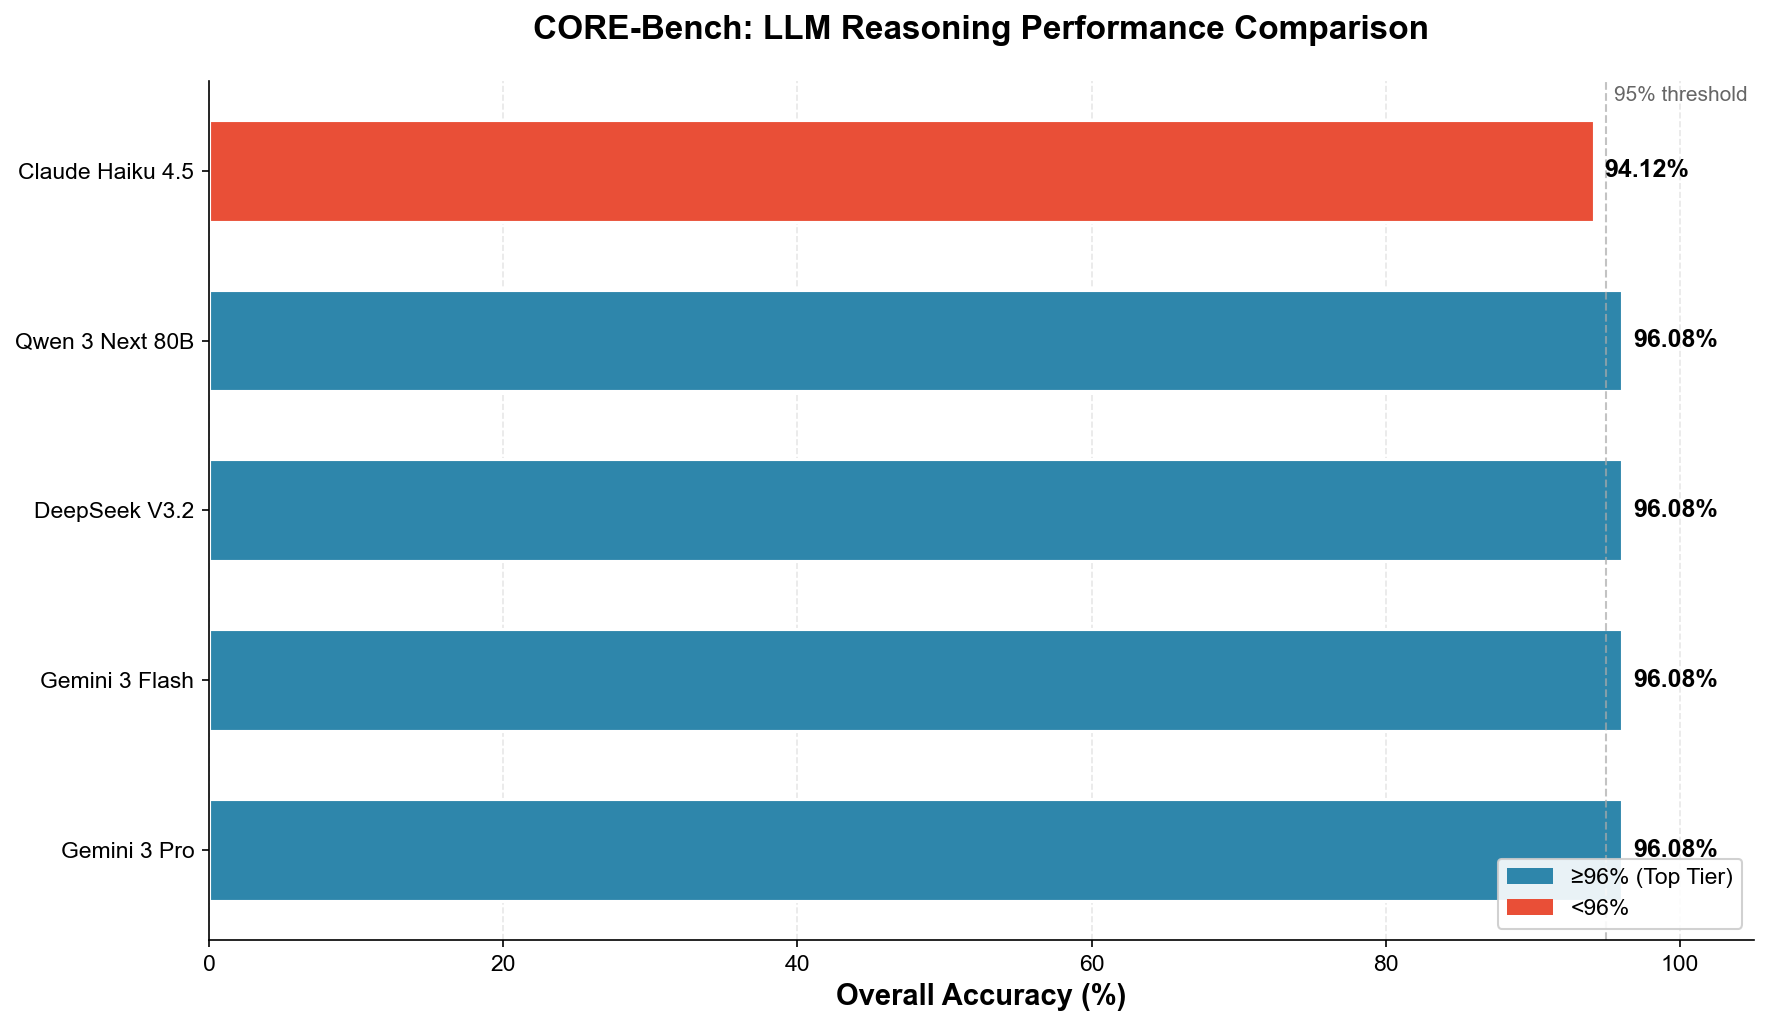

✓ Figure 1 saved to publication_figures


In [3]:
# Figure 1: Overall Model Performance Bar Chart
fig, ax = plt.subplots(figsize=(12, 7))

# Prepare data
models = df_models['model_name'].tolist()
scores = (df_models['comprehensive_reasoning_benchmark'] * 100).tolist()

# Color palette - distinguish top performers
colors = ['#2E86AB' if s >= 96 else '#E94F37' for s in scores]

# Create horizontal bar chart
bars = ax.barh(models, scores, color=colors, edgecolor='white', linewidth=1.5, height=0.6)

# Add value labels
for bar, score in zip(bars, scores):
    width = bar.get_width()
    ax.annotate(f'{score:.2f}%',
                xy=(width, bar.get_y() + bar.get_height()/2),
                xytext=(5, 0), textcoords='offset points',
                ha='left', va='center', fontsize=12, fontweight='bold')

# Styling
ax.set_xlabel('Overall Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_title('CORE-Bench: LLM Reasoning Performance Comparison', fontsize=16, fontweight='bold', pad=20)
ax.set_xlim(0, 105)
ax.axvline(x=95, color='#AAAAAA', linestyle='--', alpha=0.7, linewidth=1)
ax.text(95.5, len(models)-0.5, '95% threshold', fontsize=10, color='#666666', va='top')

# Add grid
ax.xaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Legend
legend_elements = [
    mpatches.Patch(facecolor='#2E86AB', label='≥96% (Top Tier)'),
    mpatches.Patch(facecolor='#E94F37', label='<96%')
]
ax.legend(handles=legend_elements, loc='lower right', framealpha=0.9)

plt.tight_layout()

# Save high-resolution versions
fig.savefig(output_dir / 'png' / 'fig1_overall_performance.png', dpi=300, facecolor='white')
fig.savefig(output_dir / 'svg' / 'fig1_overall_performance.svg', facecolor='white')
fig.savefig(output_dir / 'pdf' / 'fig1_overall_performance.pdf', facecolor='white')

plt.show()
print(f"✓ Figure 1 saved to {output_dir}")

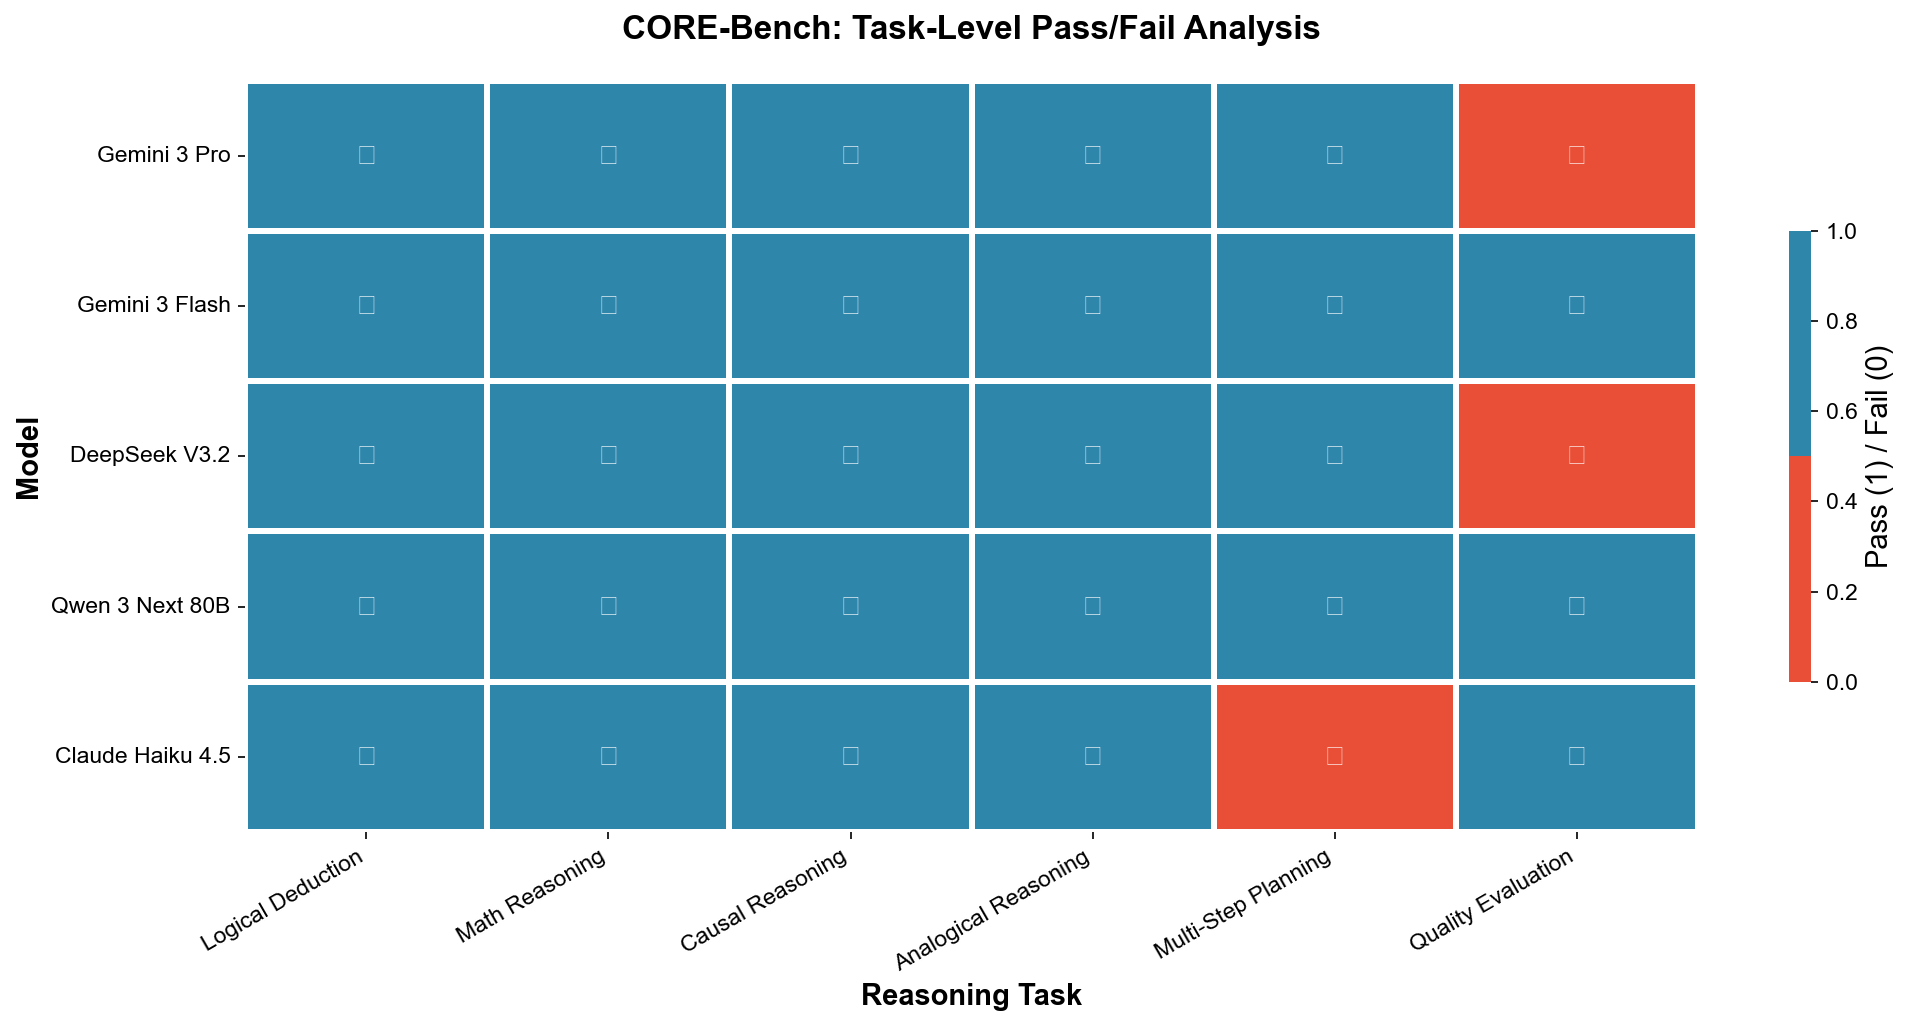

✓ Figure 2 saved to publication_figures


In [4]:
# Figure 2: Task-Level Performance Heatmap
fig, ax = plt.subplots(figsize=(14, 7))

# Prepare heatmap data - boolean tasks only (excluding overall score)
boolean_tasks = ['logical_deduction', 'math_word_problems', 'causal_reasoning', 
                 'analogical_reasoning', 'multi_step_planning', 'reasoning_quality_evaluation']

heatmap_data = []
for _, row in df_models.iterrows():
    model_row = []
    for task in boolean_tasks:
        val = row.get(task)
        if val is True:
            model_row.append(1)
        elif val is False:
            model_row.append(0)
        else:
            model_row.append(np.nan)
    heatmap_data.append(model_row)

heatmap_df = pd.DataFrame(
    heatmap_data,
    index=df_models['model_name'].tolist(),
    columns=[task_display_names[t] for t in boolean_tasks]
)

# Custom colormap: red for fail, green for pass
cmap = sns.color_palette(["#E94F37", "#2E86AB"], as_cmap=True)

# Create heatmap
sns.heatmap(heatmap_df, annot=True, fmt='.0f', cmap=cmap, 
            cbar_kws={'label': 'Pass (1) / Fail (0)', 'shrink': 0.6},
            linewidths=2, linecolor='white',
            annot_kws={'size': 14, 'weight': 'bold'},
            vmin=0, vmax=1, ax=ax)

# Replace numeric annotations with symbols
for text in ax.texts:
    if text.get_text() == '1':
        text.set_text('✓')
        text.set_color('white')
    elif text.get_text() == '0':
        text.set_text('✗')
        text.set_color('white')

ax.set_title('CORE-Bench: Task-Level Pass/Fail Analysis', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Reasoning Task', fontsize=14, fontweight='bold')
ax.set_ylabel('Model', fontsize=14, fontweight='bold')

# Rotate x labels
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

# Save
fig.savefig(output_dir / 'png' / 'fig2_task_heatmap.png', dpi=300, facecolor='white')
fig.savefig(output_dir / 'svg' / 'fig2_task_heatmap.svg', facecolor='white')
fig.savefig(output_dir / 'pdf' / 'fig2_task_heatmap.pdf', facecolor='white')

plt.show()
print(f"✓ Figure 2 saved to {output_dir}")

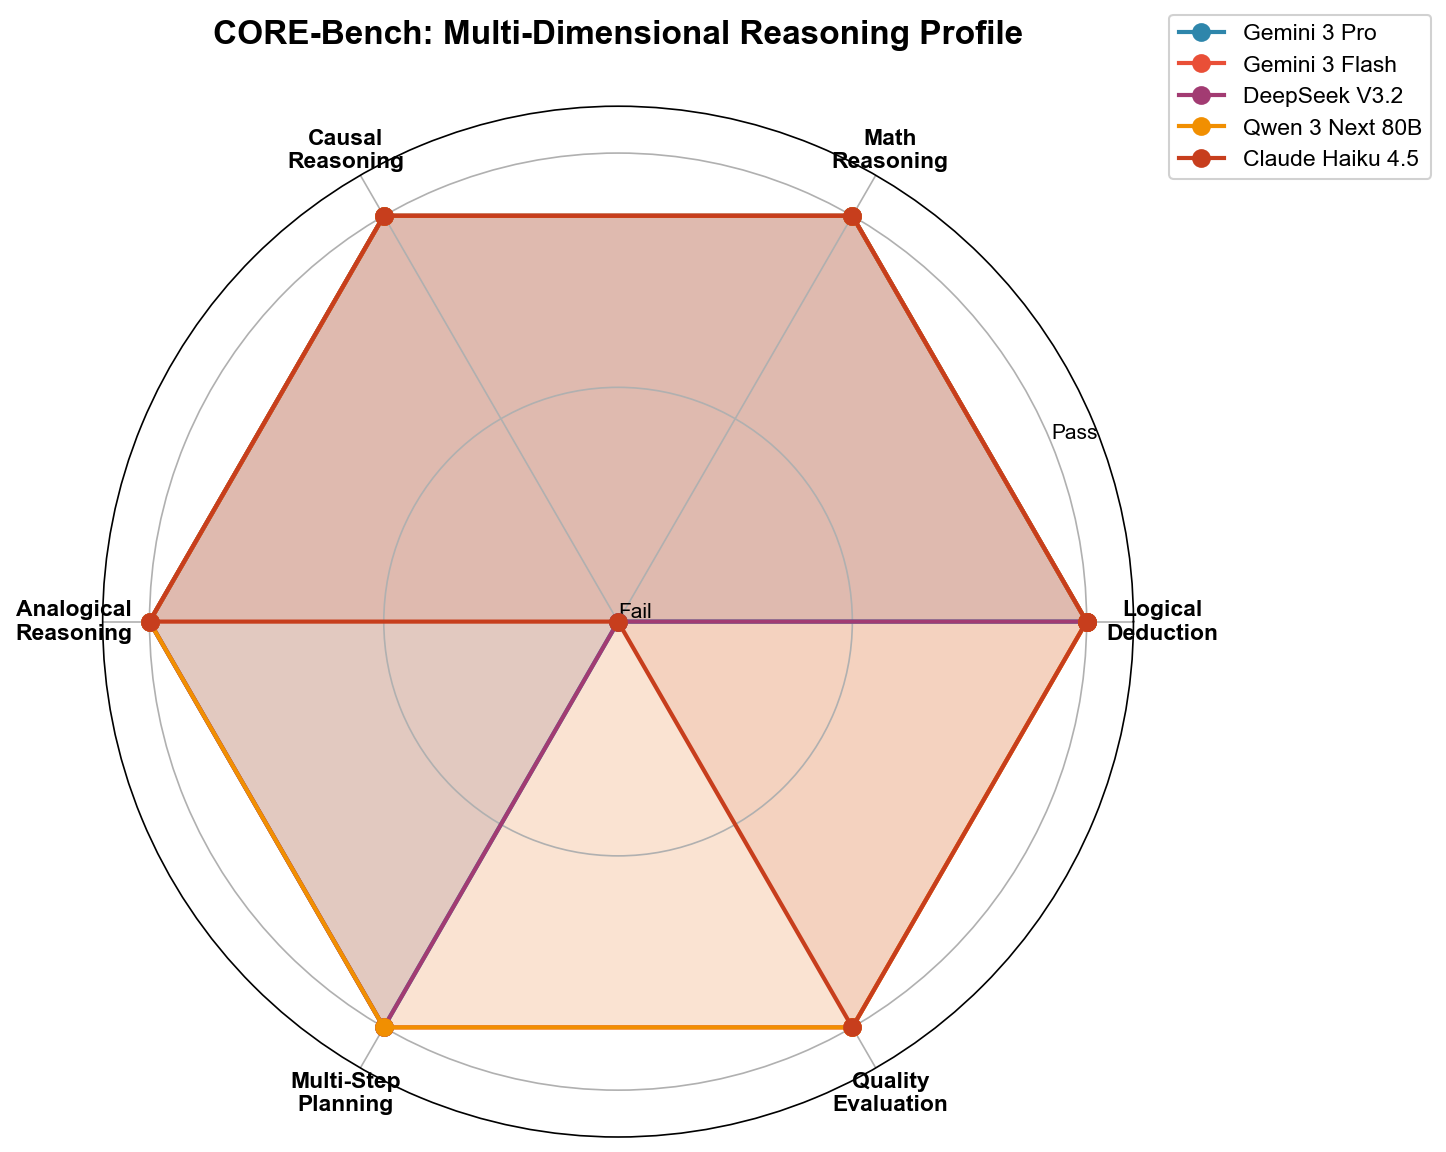

✓ Figure 3 saved to publication_figures


In [5]:
# Figure 3: Radar Chart - Multi-Dimensional Reasoning Capabilities
from math import pi

# Prepare radar data - use pass rate (1.0 or 0.0) for each core reasoning task
core_tasks = ['logical_deduction', 'math_word_problems', 'causal_reasoning', 
              'analogical_reasoning', 'multi_step_planning', 'reasoning_quality_evaluation']
task_labels = ['Logical\nDeduction', 'Math\nReasoning', 'Causal\nReasoning', 
               'Analogical\nReasoning', 'Multi-Step\nPlanning', 'Quality\nEvaluation']

# Number of variables
N = len(core_tasks)

# Compute angle for each category
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the loop

# Create figure
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Color palette for models
colors = ['#2E86AB', '#E94F37', '#A23B72', '#F18F01', '#C73E1D']

for idx, (_, row) in enumerate(df_models.iterrows()):
    values = []
    for task in core_tasks:
        val = row.get(task)
        if val is True:
            values.append(1.0)
        elif val is False:
            values.append(0.0)
        else:
            values.append(0.5)  # Unknown
    values += values[:1]  # Complete the loop
    
    ax.plot(angles, values, 'o-', linewidth=2, label=row['model_name'], 
            color=colors[idx % len(colors)], markersize=8)
    ax.fill(angles, values, alpha=0.1, color=colors[idx % len(colors)])

# Set category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(task_labels, size=11, fontweight='bold')

# Set radial ticks
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['Fail', '', 'Pass'], size=10)
ax.set_ylim(0, 1.1)

# Add title and legend
ax.set_title('CORE-Bench: Multi-Dimensional Reasoning Profile', 
             size=16, fontweight='bold', pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), framealpha=0.9)

plt.tight_layout()

# Save
fig.savefig(output_dir / 'png' / 'fig3_radar_chart.png', dpi=300, facecolor='white', bbox_inches='tight')
fig.savefig(output_dir / 'svg' / 'fig3_radar_chart.svg', facecolor='white', bbox_inches='tight')
fig.savefig(output_dir / 'pdf' / 'fig3_radar_chart.pdf', facecolor='white', bbox_inches='tight')

plt.show()
print(f"✓ Figure 3 saved to {output_dir}")

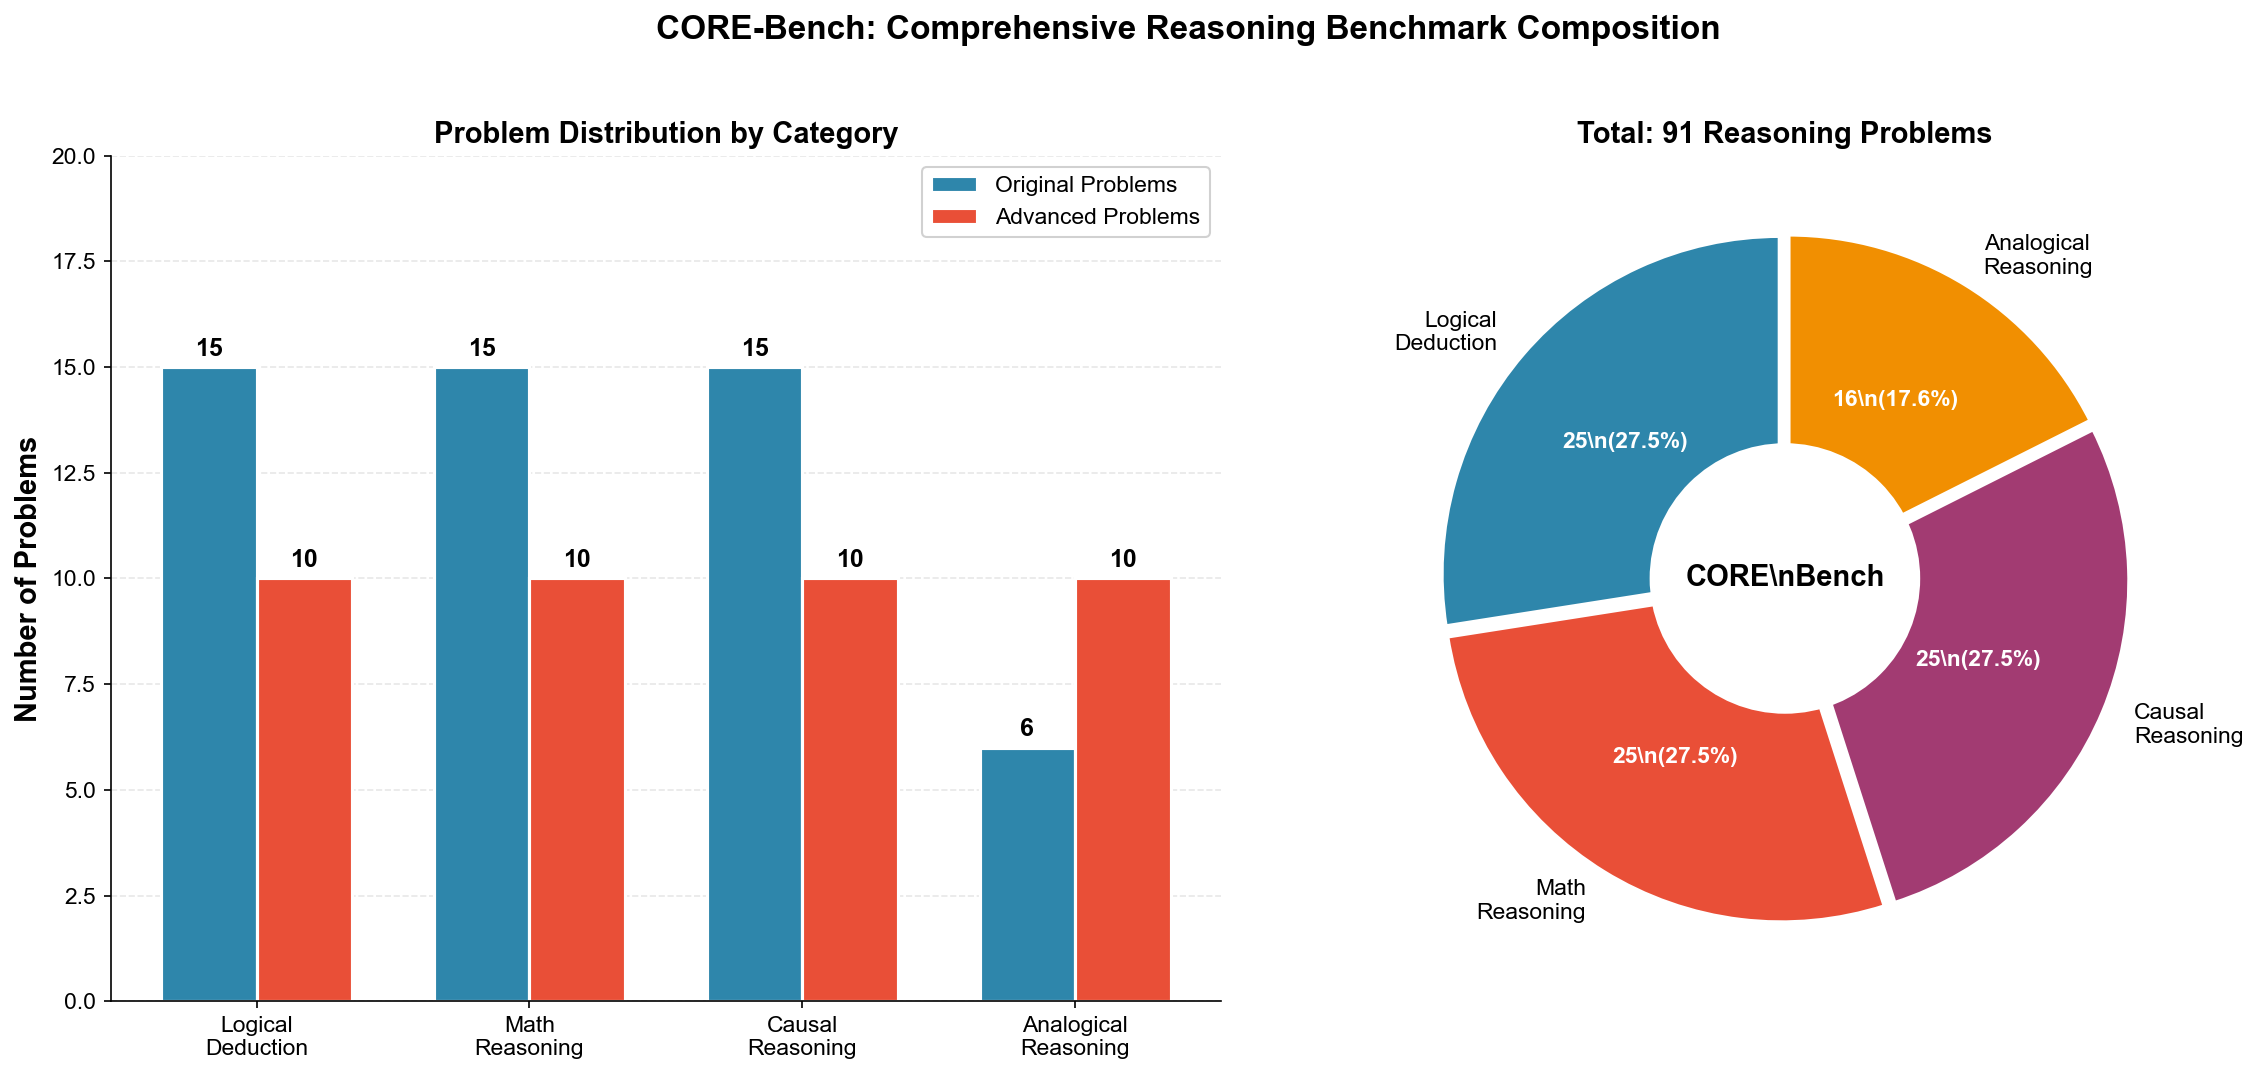

✓ Figure 4 saved to publication_figures


In [6]:
# Figure 4: Benchmark Composition - 91 Problems Across Categories
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left panel: Problem count by category
categories = ['Logical\nDeduction', 'Math\nReasoning', 'Causal\nReasoning', 'Analogical\nReasoning']
original_counts = [15, 15, 15, 6]
advanced_counts = [10, 10, 10, 10]
total_counts = [25, 25, 25, 16]

x = np.arange(len(categories))
width = 0.35

bars1 = axes[0].bar(x - width/2, original_counts, width, label='Original Problems', 
                     color='#2E86AB', edgecolor='white', linewidth=1.5)
bars2 = axes[0].bar(x + width/2, advanced_counts, width, label='Advanced Problems', 
                     color='#E94F37', edgecolor='white', linewidth=1.5)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[0].annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontweight='bold', fontsize=12)
for bar in bars2:
    height = bar.get_height()
    axes[0].annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', fontweight='bold', fontsize=12)

axes[0].set_ylabel('Number of Problems', fontsize=14, fontweight='bold')
axes[0].set_title('Problem Distribution by Category', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories, fontsize=11)
axes[0].legend(loc='upper right', framealpha=0.9)
axes[0].set_ylim(0, 20)
axes[0].yaxis.grid(True, linestyle='--', alpha=0.3)
axes[0].set_axisbelow(True)

# Right panel: Pie chart of total distribution
colors_pie = ['#2E86AB', '#E94F37', '#A23B72', '#F18F01']
explode = (0.02, 0.02, 0.02, 0.02)

wedges, texts, autotexts = axes[1].pie(
    total_counts, 
    labels=categories,
    autopct=lambda pct: f'{int(pct/100*91)}\\n({pct:.1f}%)',
    explode=explode,
    colors=colors_pie,
    startangle=90,
    textprops={'fontsize': 11},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_color('white')
    autotext.set_fontsize(11)

axes[1].set_title('Total: 91 Reasoning Problems', fontsize=14, fontweight='bold')

# Add center circle for donut effect
centre_circle = plt.Circle((0, 0), 0.4, fc='white')
axes[1].add_artist(centre_circle)
axes[1].text(0, 0, 'CORE\\nBench', ha='center', va='center', fontsize=14, fontweight='bold')

plt.suptitle('CORE-Bench: Comprehensive Reasoning Benchmark Composition', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save
fig.savefig(output_dir / 'png' / 'fig4_benchmark_composition.png', dpi=300, facecolor='white', bbox_inches='tight')
fig.savefig(output_dir / 'svg' / 'fig4_benchmark_composition.svg', facecolor='white', bbox_inches='tight')
fig.savefig(output_dir / 'pdf' / 'fig4_benchmark_composition.pdf', facecolor='white', bbox_inches='tight')

plt.show()
print(f"✓ Figure 4 saved to {output_dir}")

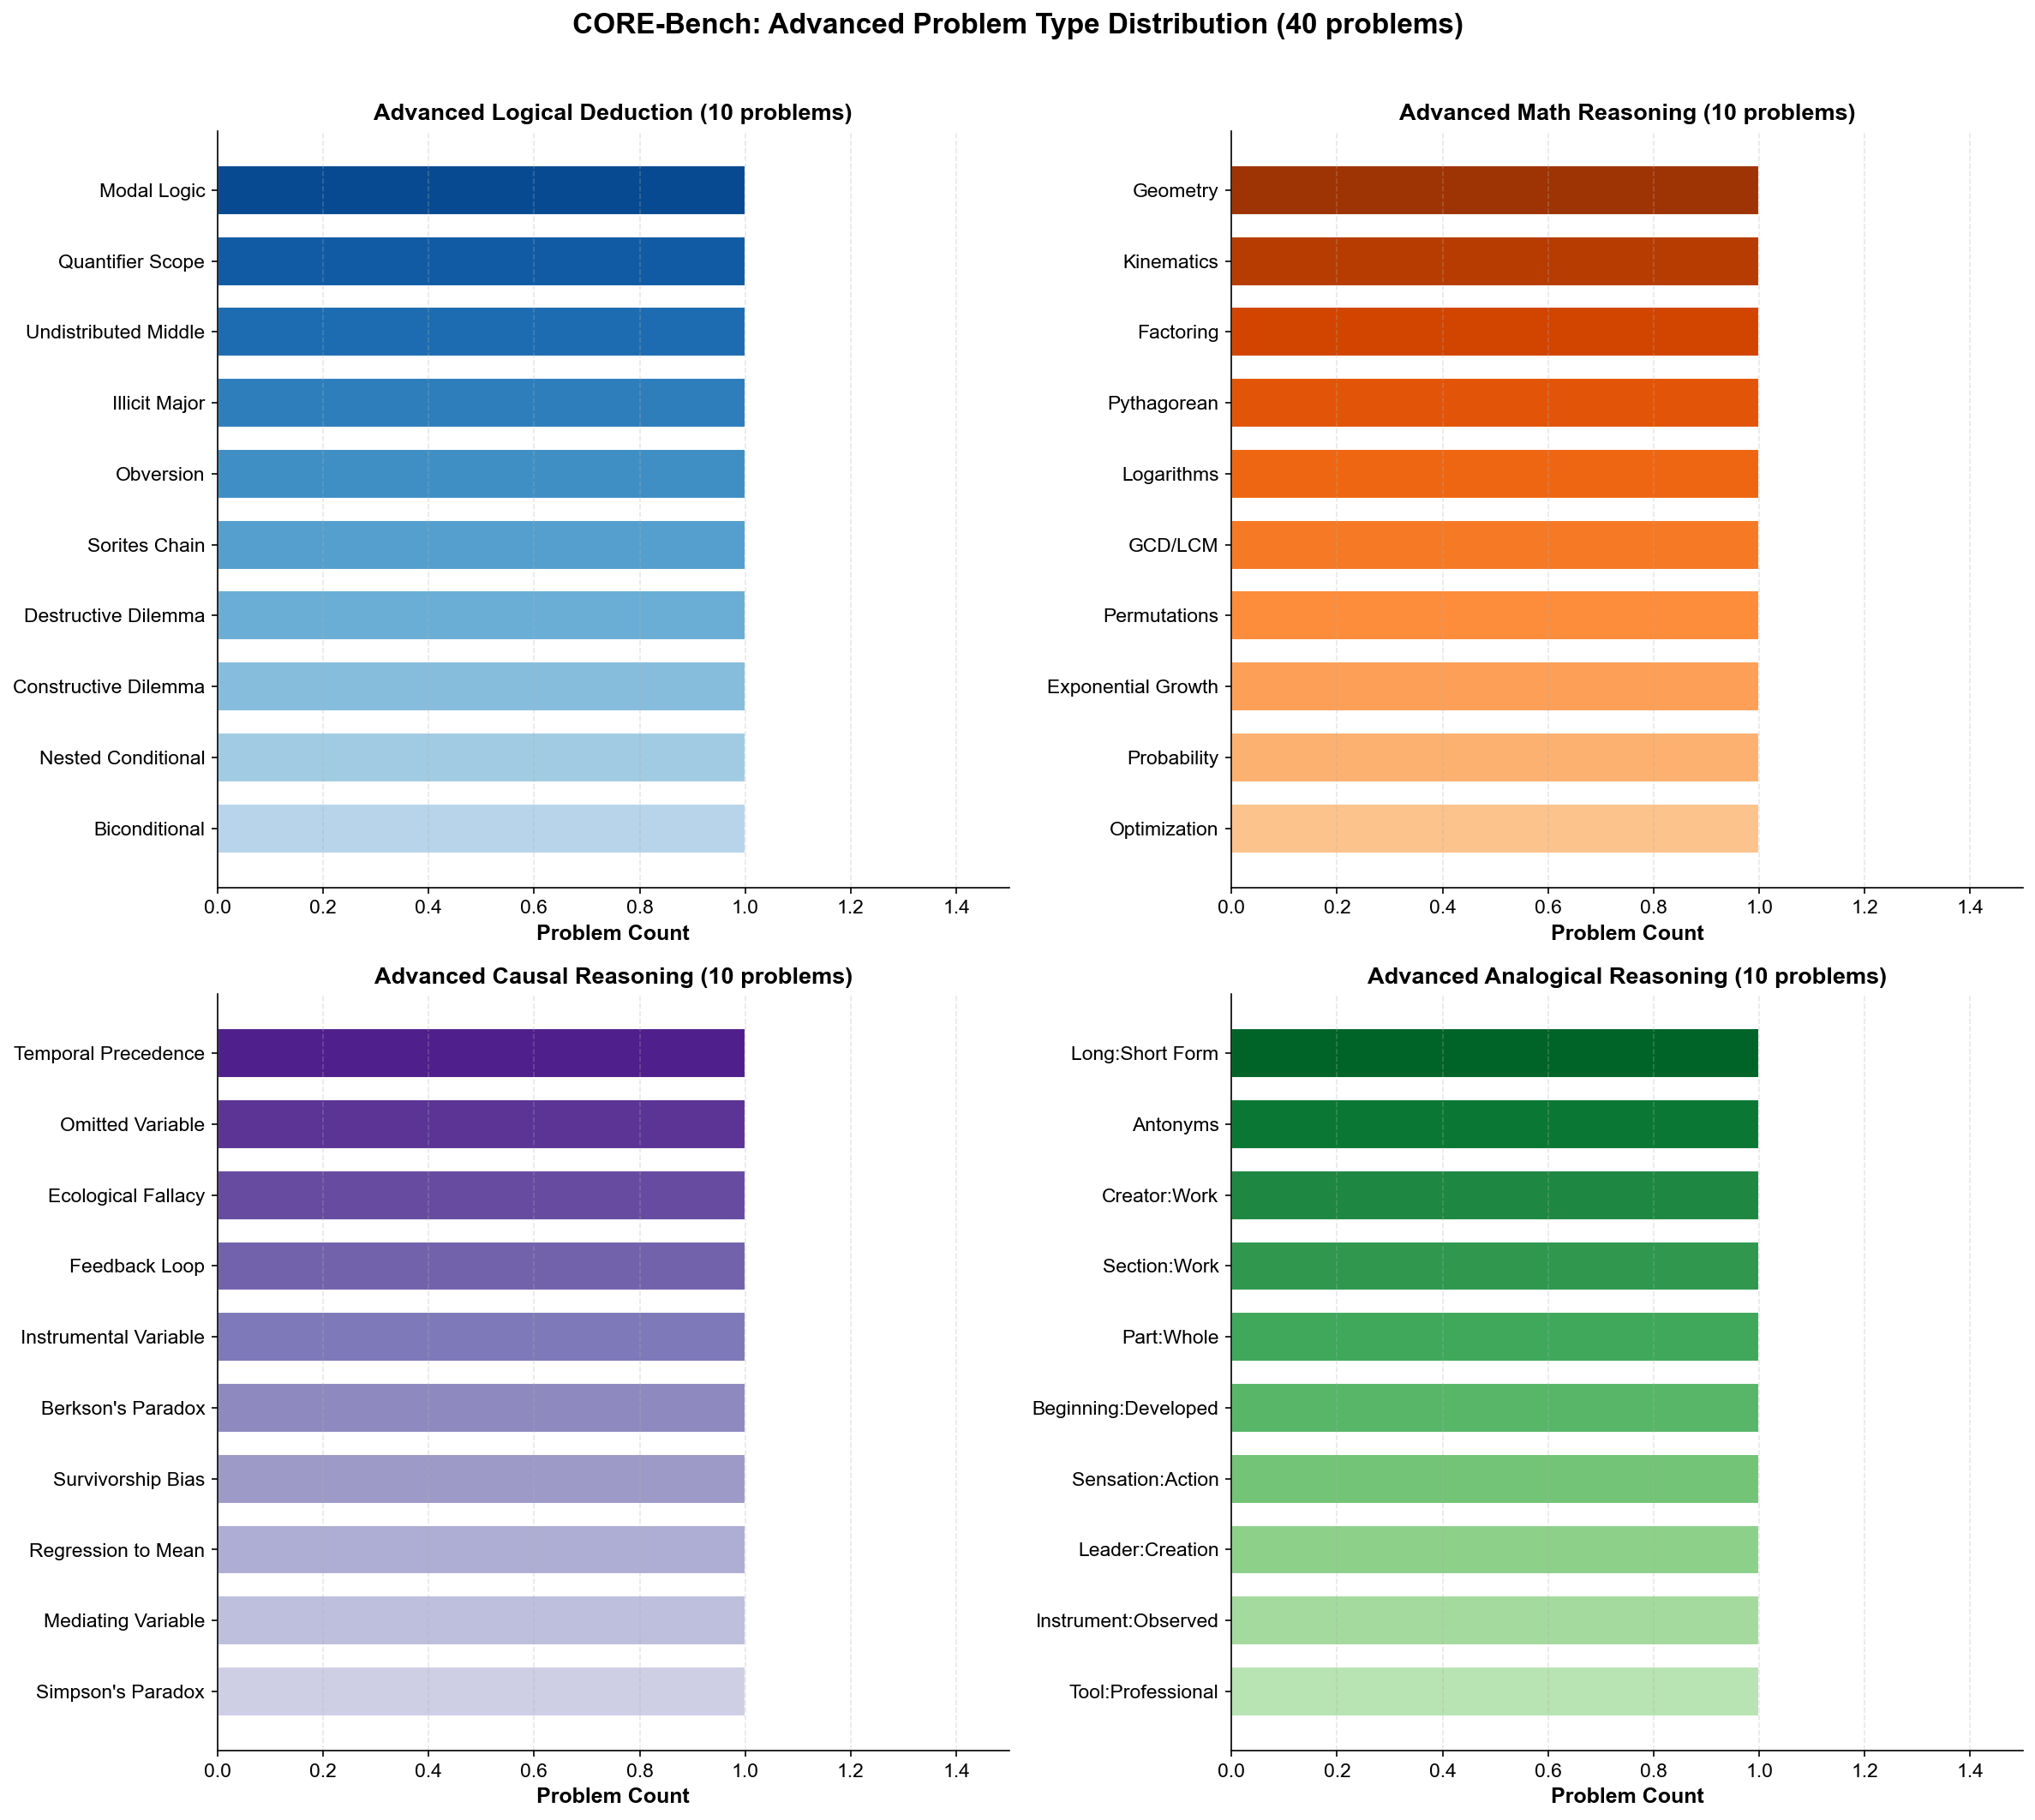

✓ Figure 5 saved to publication_figures


In [7]:
# Figure 5: Advanced Problem Types - Detailed Breakdown
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Advanced Logic Problem Types
logic_types = ['Biconditional', 'Nested Conditional', 'Constructive Dilemma', 
               'Destructive Dilemma', 'Sorites Chain', 'Obversion',
               'Illicit Major', 'Undistributed Middle', 'Quantifier Scope', 'Modal Logic']
logic_colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(logic_types)))

axes[0, 0].barh(logic_types, [1]*len(logic_types), color=logic_colors, edgecolor='white', height=0.7)
axes[0, 0].set_xlabel('Problem Count', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Advanced Logical Deduction (10 problems)', fontsize=13, fontweight='bold')
axes[0, 0].set_xlim(0, 1.5)
axes[0, 0].xaxis.grid(True, linestyle='--', alpha=0.3)

# Advanced Math Problem Types  
math_types = ['Optimization', 'Probability', 'Exponential Growth', 
              'Permutations', 'GCD/LCM', 'Logarithms',
              'Pythagorean', 'Factoring', 'Kinematics', 'Geometry']
math_colors = plt.cm.Oranges(np.linspace(0.3, 0.9, len(math_types)))

axes[0, 1].barh(math_types, [1]*len(math_types), color=math_colors, edgecolor='white', height=0.7)
axes[0, 1].set_xlabel('Problem Count', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Advanced Math Reasoning (10 problems)', fontsize=13, fontweight='bold')
axes[0, 1].set_xlim(0, 1.5)
axes[0, 1].xaxis.grid(True, linestyle='--', alpha=0.3)

# Advanced Causal Problem Types
causal_types = ["Simpson's Paradox", 'Mediating Variable', 'Regression to Mean',
                'Survivorship Bias', "Berkson's Paradox", 'Instrumental Variable',
                'Feedback Loop', 'Ecological Fallacy', 'Omitted Variable', 'Temporal Precedence']
causal_colors = plt.cm.Purples(np.linspace(0.3, 0.9, len(causal_types)))

axes[1, 0].barh(causal_types, [1]*len(causal_types), color=causal_colors, edgecolor='white', height=0.7)
axes[1, 0].set_xlabel('Problem Count', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Advanced Causal Reasoning (10 problems)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlim(0, 1.5)
axes[1, 0].xaxis.grid(True, linestyle='--', alpha=0.3)

# Advanced Analogy Problem Types
analogy_types = ['Tool:Professional', 'Instrument:Observed', 'Leader:Creation',
                 'Sensation:Action', 'Beginning:Developed', 'Part:Whole',
                 'Section:Work', 'Creator:Work', 'Antonyms', 'Long:Short Form']
analogy_colors = plt.cm.Greens(np.linspace(0.3, 0.9, len(analogy_types)))

axes[1, 1].barh(analogy_types, [1]*len(analogy_types), color=analogy_colors, edgecolor='white', height=0.7)
axes[1, 1].set_xlabel('Problem Count', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Advanced Analogical Reasoning (10 problems)', fontsize=13, fontweight='bold')
axes[1, 1].set_xlim(0, 1.5)
axes[1, 1].xaxis.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('CORE-Bench: Advanced Problem Type Distribution (40 problems)', 
             fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()

# Save
fig.savefig(output_dir / 'png' / 'fig5_advanced_problems.png', dpi=300, facecolor='white', bbox_inches='tight')
fig.savefig(output_dir / 'svg' / 'fig5_advanced_problems.svg', facecolor='white', bbox_inches='tight')
fig.savefig(output_dir / 'pdf' / 'fig5_advanced_problems.pdf', facecolor='white', bbox_inches='tight')

plt.show()
print(f"✓ Figure 5 saved to {output_dir}")

In [ ]:
# Figure 6: Comprehensive Dashboard - Multi-Panel Publication Figure
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 1], hspace=0.3, wspace=0.3)

# Panel A: Overall Performance (top-left)
ax1 = fig.add_subplot(gs[0, 0])
models = df_models['model_name'].tolist()
scores = (df_models['comprehensive_reasoning_benchmark'] * 100).tolist()
colors = ['#2E86AB' if s >= 96 else '#E94F37' for s in scores]
bars = ax1.barh(models, scores, color=colors, edgecolor='white', height=0.6)
for bar, score in zip(bars, scores):
    ax1.annotate(f'{score:.1f}%', xy=(bar.get_width()-5, bar.get_y()+bar.get_height()/2),
                 ha='right', va='center', fontsize=10, fontweight='bold', color='white')
ax1.set_xlabel('Overall Accuracy (%)', fontsize=11, fontweight='bold')
ax1.set_title('A. Model Performance Ranking', fontsize=13, fontweight='bold')
ax1.set_xlim(0, 100)
ax1.xaxis.grid(True, linestyle='--', alpha=0.3)

# Panel B: Task Pass/Fail Matrix (top-center and top-right)
ax2 = fig.add_subplot(gs[0, 1:])
boolean_tasks = ['logical_deduction', 'math_word_problems', 'causal_reasoning', 
                 'analogical_reasoning', 'multi_step_planning', 'reasoning_quality_evaluation']
heatmap_data = []
for _, row in df_models.iterrows():
    model_row = [1 if row.get(task) is True else 0 for task in boolean_tasks]
    heatmap_data.append(model_row)
heatmap_df = pd.DataFrame(heatmap_data, index=models,
    columns=['Logic', 'Math', 'Causal', 'Analogy', 'Planning', 'Quality'])
cmap = sns.color_palette(["#E94F37", "#2E86AB"], as_cmap=True)
sns.heatmap(heatmap_df, annot=True, fmt='.0f', cmap=cmap, cbar=False,
            linewidths=2, linecolor='white', annot_kws={'size': 12, 'weight': 'bold'},
            vmin=0, vmax=1, ax=ax2)
for text in ax2.texts:
    text.set_text('✓' if text.get_text() == '1' else '✗')
    text.set_color('white')
ax2.set_title('B. Task-Level Pass/Fail Matrix', fontsize=13, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right')

# Panel C: Benchmark Composition (middle-left)
ax3 = fig.add_subplot(gs[1, 0])
categories = ['Logic', 'Math', 'Causal', 'Analogy']
original = [15, 15, 15, 6]
advanced = [10, 10, 10, 10]
x = np.arange(len(categories))
ax3.bar(x, original, 0.6, label='Original', color='#2E86AB', edgecolor='white')
ax3.bar(x, advanced, 0.6, bottom=original, label='Advanced', color='#E94F37', edgecolor='white')
for i, (o, a) in enumerate(zip(original, advanced)):
    ax3.text(i, o+a+0.5, str(o+a), ha='center', fontweight='bold', fontsize=11)
ax3.set_xticks(x)
ax3.set_xticklabels(categories)
ax3.set_ylabel('Problems', fontsize=11, fontweight='bold')
ax3.set_title('C. Problem Distribution (n=91)', fontsize=13, fontweight='bold')
ax3.legend(loc='upper right', fontsize=9)
ax3.set_ylim(0, 30)

# Panel D: Failure Analysis (middle-center)
ax4 = fig.add_subplot(gs[1, 1])
failure_data = {
    'Multi-Step Planning': ['Claude Haiku 4.5'],
    'Quality Evaluation': ['Gemini 3 Pro', 'DeepSeek V3.2']
}
failure_counts = {'Multi-Step\nPlanning': 1, 'Quality\nEvaluation': 2}
bars = ax4.bar(failure_counts.keys(), failure_counts.values(), 
               color=['#E94F37', '#A23B72'], edgecolor='white', width=0.5)
for bar in bars:
    ax4.annotate(f'{int(bar.get_height())} model(s)',
                 xy=(bar.get_x()+bar.get_width()/2, bar.get_height()+0.1),
                 ha='center', fontweight='bold', fontsize=11)
ax4.set_ylabel('Failure Count', fontsize=11, fontweight='bold')
ax4.set_title('D. Task Failure Distribution', fontsize=13, fontweight='bold')
ax4.set_ylim(0, 3)

# Panel E: Perfect vs Imperfect Models (middle-right)
ax5 = fig.add_subplot(gs[1, 2])
perfect = 2  # Gemini 3 Flash, Qwen 3 Next 80B
imperfect = 3  # Others
sizes = [perfect, imperfect]
labels = [f'All Tasks Passed\n({perfect} models)', f'1+ Task Failed\n({imperfect} models)']
colors_pie = ['#2E86AB', '#E94F37']
wedges, texts, autotexts = ax5.pie(sizes, labels=labels, autopct='%1.0f%%',
                                    colors=colors_pie, startangle=90,
                                    wedgeprops={'edgecolor': 'white', 'linewidth': 2})
for autotext in autotexts:
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)
ax5.set_title('E. Model Completeness', fontsize=13, fontweight='bold')

# Panel F: Key Findings Summary (bottom row spanning all)
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')
summary_text = """
KEY FINDINGS FROM CORE-BENCH EVALUATION

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 OVERALL PERFORMANCE                          🎯 TOP PERFORMERS                              ⚠️ CHALLENGE AREAS
• 4 of 5 models achieved 96.08% accuracy        • Gemini 3 Flash: Perfect on all 6 tasks       • Quality Evaluation: 2 failures (40%)
• Claude Haiku 4.5 scored 94.12% (lowest)       • Qwen 3 Next 80B: Perfect on all 6 tasks      • Multi-Step Planning: 1 failure (20%)
• All models passed core reasoning tasks        • Both demonstrated robust reasoning           • Core reasoning tasks: 0 failures

📈 BENCHMARK STATISTICS                         🔬 ADVANCED PROBLEMS                           📋 RECOMMENDATIONS
• Total: 91 reasoning problems                  • 40 advanced problems added (44% of total)    • Re-run with expanded 91-problem set
• 4 categories tested                           • Simpson's Paradox, Modal Logic, etc.         • Focus testing on Quality Evaluation
• 6 evaluation tasks + 1 comprehensive          • Designed to challenge frontier models        • Add per-problem accuracy tracking

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""
ax6.text(0.5, 0.5, summary_text, transform=ax6.transAxes, fontsize=11,
         verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='#f8f9fa', 
                                            edgecolor='#dee2e6', linewidth=2))

plt.suptitle('CORE-Bench: Comprehensive LLM Reasoning Evaluation Dashboard', 
             fontsize=18, fontweight='bold', y=0.98)

# Save
fig.savefig(output_dir / 'png' / 'fig6_dashboard.png', dpi=300, facecolor='white', bbox_inches='tight')
fig.savefig(output_dir / 'svg' / 'fig6_dashboard.svg', facecolor='white', bbox_inches='tight')
fig.savefig(output_dir / 'pdf' / 'fig6_dashboard.pdf', facecolor='white', bbox_inches='tight')

plt.show()
print(f"✓ Figure 6 (Dashboard) saved to {output_dir}")